In [2]:
# ============================================================
# Bias–Variance Decomposition for Tree-Based Models
# Decision Tree vs Random Forest vs Gradient Boosting
# Full unified experiment pipeline — one cell
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import os

print("Running on full unified pipeline...")

# ------------------------------------------------------------
# Create output directory
# ------------------------------------------------------------
os.makedirs("bv_figs", exist_ok=True)

# ------------------------------------------------------------
# 1. Dataset Creation
# ------------------------------------------------------------
X, y = make_moons(n_samples=2000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ------------------------------------------------------------
# 2. Helper: plot decision boundaries
# ------------------------------------------------------------
def plot_decision_boundary(model, X, y, title, filename):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    cmap = ListedColormap(["#1f77b4", "#ff7f0e"])
    plt.contourf(xx, yy, Z, alpha=0.35, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap=cmap, edgecolor="k")
    plt.title(title)
    plt.savefig(f"bv_figs/{filename}", dpi=150)
    plt.close()


# ------------------------------------------------------------
# 3. Experiment Settings
# ------------------------------------------------------------
n_estimators_list = [1, 5, 10, 20, 50, 100]
base_depth = 3

train_errors = {"DT": [], "RF": [], "GB": []}
test_errors = {"DT": [], "RF": [], "GB": []}

# ------------------------------------------------------------
# 4. Main Experiment Loop
# ------------------------------------------------------------
for n_est in n_estimators_list:

    # Decision Tree (no n_estimators, reuse depth)
    dt_model = DecisionTreeClassifier(max_depth=base_depth, random_state=0)
    dt_model.fit(X_train, y_train)
    train_errors["DT"].append(1 - accuracy_score(y_train, dt_model.predict(X_train)))
    test_errors["DT"].append(1 - accuracy_score(y_test, dt_model.predict(X_test)))

    # Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=base_depth,
        random_state=0
    )
    rf_model.fit(X_train, y_train)
    train_errors["RF"].append(1 - accuracy_score(y_train, rf_model.predict(X_train)))
    test_errors["RF"].append(1 - accuracy_score(y_test, rf_model.predict(X_test)))

    # Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=n_est,
        max_depth=base_depth,
        random_state=0
    )
    gb_model.fit(X_train, y_train)
    train_errors["GB"].append(1 - accuracy_score(y_train, gb_model.predict(X_train)))
    test_errors["GB"].append(1 - accuracy_score(y_test, gb_model.predict(X_test)))


# ------------------------------------------------------------
# 5. Plot Training vs Test Curves
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.plot(n_estimators_list, test_errors["DT"], "o-", label="Decision Tree")
plt.plot(n_estimators_list, test_errors["RF"], "o-", label="Random Forest")
plt.plot(n_estimators_list, test_errors["GB"], "o-", label="Gradient Boosting")

plt.xlabel("Number of Estimators")
plt.ylabel("Test Error")
plt.title("Test Error vs Number of Estimators")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("bv_figs/error_curve.png", dpi=150)
plt.close()


# ------------------------------------------------------------
# 6. Empirical Bias–Variance Decomposition
# ------------------------------------------------------------
def empirical_bias_variance(model_class, **params):
    """
    Compute empirical bias–variance decomposition.
    """
    M = 30  # number of bootstrap datasets
    preds = []

    for seed in range(M):
        idx = np.random.choice(len(X_train), len(X_train), replace=True)
        Xb, yb = X_train[idx], y_train[idx]

        model = model_class(**params)
        model.fit(Xb, yb)
        preds.append(model.predict_proba(X_test)[:, 1])

    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)

    bias2 = np.mean((mean_pred - y_test)**2)
    variance = np.mean(np.var(preds, axis=0))
    return bias2, variance


bv_DT = empirical_bias_variance(DecisionTreeClassifier, max_depth=base_depth)
bv_RF = empirical_bias_variance(RandomForestClassifier, n_estimators=50, max_depth=base_depth)
bv_GB = empirical_bias_variance(GradientBoostingClassifier, n_estimators=50, max_depth=base_depth)

# Bar plot
labels = ["Decision Tree", "Random Forest", "Gradient Boosting"]
bias_vals = [bv_DT[0], bv_RF[0], bv_GB[0]]
var_vals  = [bv_DT[1], bv_RF[1], bv_GB[1]]

x = np.arange(len(labels))

plt.figure(figsize=(8,6))
plt.bar(x - 0.2, bias_vals, 0.4, label="Bias²")
plt.bar(x + 0.2, var_vals, 0.4, label="Variance")
plt.xticks(x, labels, rotation=20)
plt.ylabel("Error Components")
plt.title("Bias–Variance Decomposition")
plt.legend()
plt.savefig("bv_figs/bias_variance_barplot.png", dpi=150)
plt.close()


# ------------------------------------------------------------
# 7. Decision Boundary Plots
# ------------------------------------------------------------
plot_decision_boundary(dt_model, X_train, y_train,
                       "Decision Tree Boundary",
                       "decision_boundary_tree.png")

plot_decision_boundary(rf_model, X_train, y_train,
                       "Random Forest Boundary",
                       "decision_boundary_rf.png")

plot_decision_boundary(gb_model, X_train, y_train,
                       "Gradient Boosting Boundary",
                       "decision_boundary_gb.png")


print("All plots saved in folder: bv_figs/")
print("Your assignment visuals are ready!")


Running on full unified pipeline...
All plots saved in folder: bv_figs/
Your assignment visuals are ready!


Found images: ['bias_variance_barplot.png', 'decision_boundary_gb.png', 'decision_boundary_rf.png', 'decision_boundary_tree.png', 'error_curve.png']


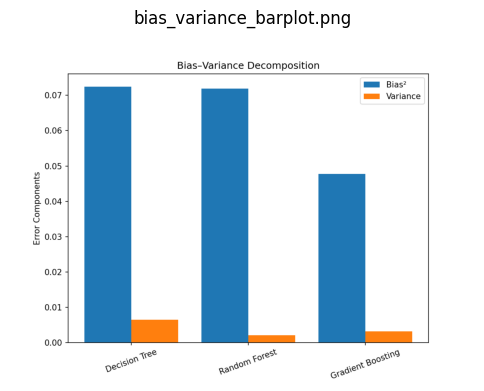

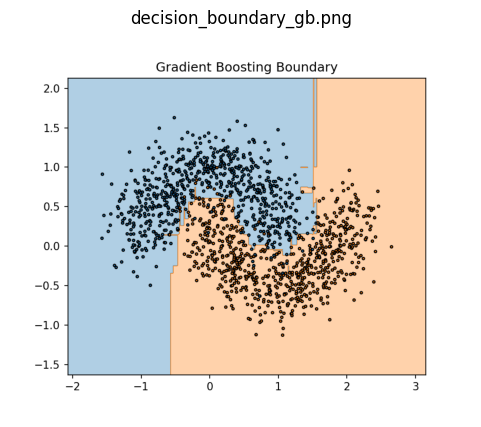

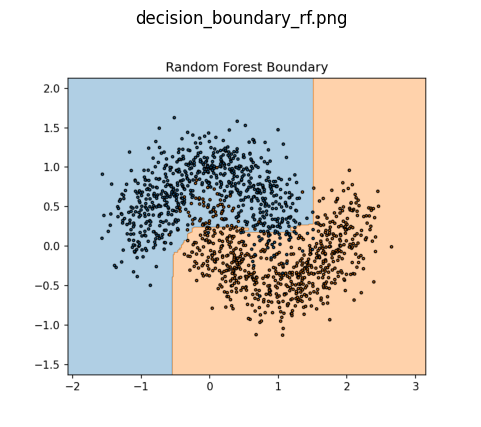

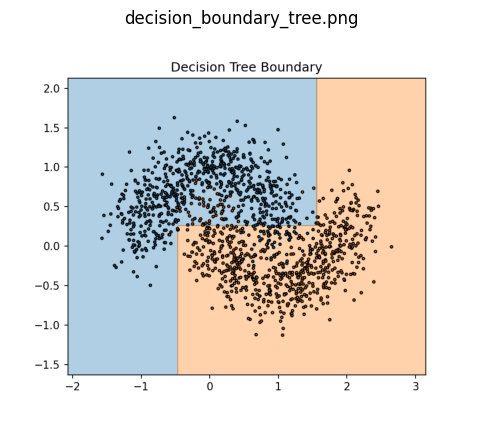

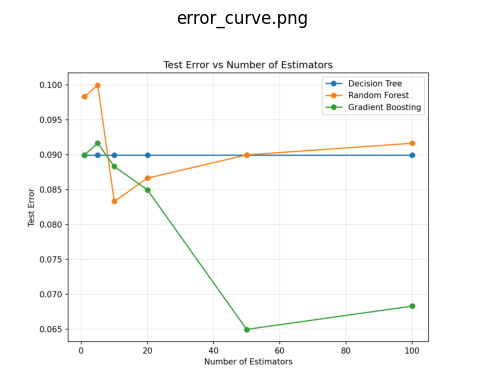

In [3]:
import matplotlib.pyplot as plt
import os

folder = "bv_figs"

# List all images in folder
imgs = sorted([f for f in os.listdir(folder) if f.endswith(".png")])

print("Found images:", imgs)

# Display each figure
for img in imgs:
    plt.figure(figsize=(6,5))
    plt.imshow(plt.imread(os.path.join(folder, img)))
    plt.title(img)
    plt.axis("off")
    plt.show()
